# Importation des bibliothéques

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import spacy 
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from collections import Counter


import common as cmn

import string
import re
import unicodedata
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (accuracy_score,f1_score,precision_score,recall_score,roc_auc_score)
from time import time
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


[nltk_data] Downloading package punkt to /home/anyes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/anyes/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/anyes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/anyes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Etape 0 : Chargement de données movies

Dans cette partie nous allons rechargé les données de movies afin d'effectuer l'analyse de sentiments

In [4]:
path = "./datasets/movies/movies1000/"
alltxts,alllabs = cmn.load_movies(path)

Création du DataFrame

In [5]:
movies_df = pd.DataFrame()
movies_df['text'] = alltxts
movies_df['label'] = alllabs

movies_df

text  label
0     the kids in the hall are an acquired taste . \...      0
1     capsule : a science fiction allegory . \nat th...      0
2     there is a rule when it comes to movies . \na ...      0
3     it's amazing how a comedian can have the some ...      0
4     absolute power , the new film produced and dir...      0
...                                                 ...    ...
1995  as i walked out of crouching tiger , hidden dr...      1
1996  when andy leaves for cowboy camp , his mother ...      1
1997  plot : a bunch of bad guys dressed up as elvis...      1
1998  trees lounge is the directoral debut from one ...      1
1999  ingredients : neophyte lawyer , legal situatio...      1

[2000 rows x 2 columns]

# Etape 1 : Visualisation des données

Dans cette partie, nous allons faire quelques visualisations de données

## 1.1 Distribution des classes

D'aprés le graphe ci-dessous, on peut remarqué qu'il y a autant de review négatif que de review positif

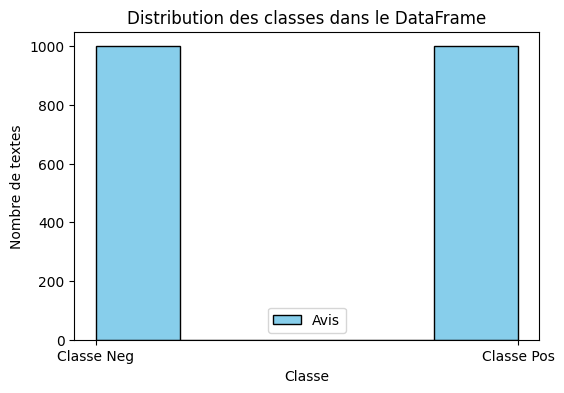

In [5]:

plt.figure(figsize=(6, 4))  # Définir la taille de la figure
plt.hist(movies_df['label'], bins=5, color='skyblue', edgecolor='black')  # Définir le nombre de bacs et les couleurs
plt.title('Distribution des classes dans le DataFrame')  # Ajouter un titre au graphique
plt.xlabel('Classe')  # Ajouter une étiquette pour l'axe x
plt.ylabel('Nombre de textes')  # Ajouter une étiquette pour l'axe y
plt.xticks([0, 1], labels=['Classe Neg', 'Classe Pos'])  # Définir les étiquettes de l'axe x
plt.legend(labels=['Avis'])  # Ajouter une légende
plt.show()


## 1.2 Longueur des textes

### 1.2.1 Sur tout le dataframe

Création d'une nouvelle colonne qui associe pour chaque text sa longueur, cela va nous permettre d'analyser les longueurs des texts

In [6]:
movies_df['text_length'] = movies_df['text'].apply(len)
movies_df

text  label  text_length
0     the kids in the hall are an acquired taste . \...      0         2342
1     capsule : a science fiction allegory . \nat th...      0         1621
2     there is a rule when it comes to movies . \na ...      0         2525
3     it's amazing how a comedian can have the some ...      0         2572
4     absolute power , the new film produced and dir...      0         4591
...                                                 ...    ...          ...
1995  as i walked out of crouching tiger , hidden dr...      1         3607
1996  when andy leaves for cowboy camp , his mother ...      1         5259
1997  plot : a bunch of bad guys dressed up as elvis...      1         5269
1998  trees lounge is the directoral debut from one ...      1         1088
1999  ingredients : neophyte lawyer , legal situatio...      1         2151

[2000 rows x 3 columns]

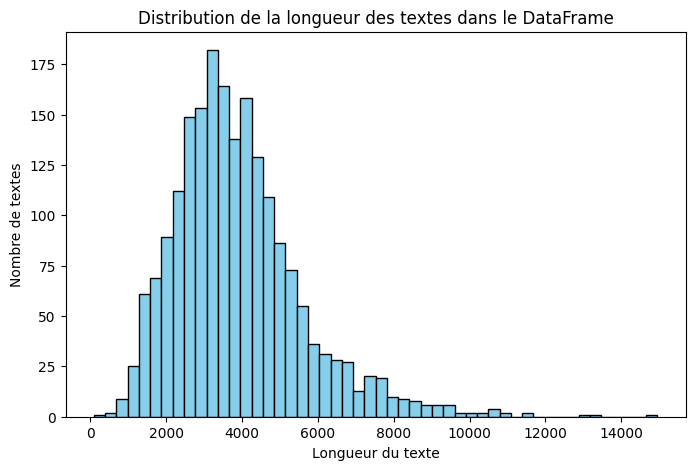

In [7]:
plt.figure(figsize=(8, 5))  # Définir la taille de la figure
plt.hist(movies_df['text_length'], bins=50, color='skyblue', edgecolor='black')  
plt.title('Distribution de la longueur des textes dans le DataFrame')  # Ajouter un titre au graphique
plt.xlabel('Longueur du texte')  # Ajouter une étiquette pour l'axe x
plt.ylabel('Nombre de textes')  # Ajouter une étiquette pour l'axe y
plt.show()

### 1.2.2 Par classe

D'aprés les graphes de distribution de la longueur des texts, on peut dire qu'à première vu les 2 classes ont la même distribution.

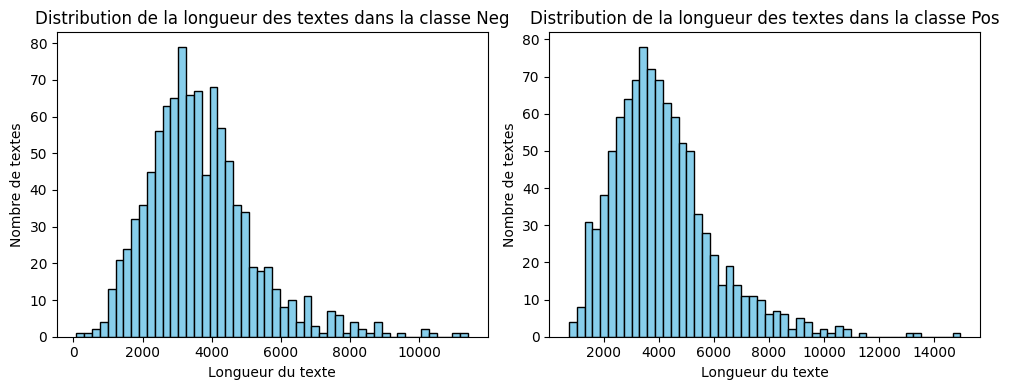

In [7]:
# Création des sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Affichage de l'histogramme de la longueur des textes
ax1.hist(movies_df[movies_df['label'] == 0]['text_length'], bins=50, color='skyblue', edgecolor='black')
ax1.set_title('Distribution de la longueur des textes dans la classe Neg')
ax1.set_xlabel('Longueur du texte')
ax1.set_ylabel('Nombre de textes')

# Affichage de l'histogramme de la distribution des classes
ax2.hist(movies_df[movies_df['label'] == 1]['text_length'], bins=50, color='skyblue', edgecolor='black')
ax2.set_title('Distribution de la longueur des textes dans la classe Pos')
ax2.set_xlabel('Longueur du texte')
ax2.set_ylabel('Nombre de textes')

# Afficher les sous-graphiques
plt.tight_layout()
plt.show()


# Etape 2 : Transformation paramétrique du texte (pré-traitements)


On teste les cas suivants:
- suppression de la ponctuation
- transformation en minuscule ou pas
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- lemmatization 


Ici nous verifions d'abord dans un premier lieu l'ensemble des fonction qu'on va utiliser

### 2.1 Suppression de la ponctuation

Commençons par la suppression de la ponctuation

In [8]:
def remove_ponctuation(sentence):
    punc = string.punctuation  
    punc += '\n\r\t'
    return sentence.translate(str.maketrans(punc, ' ' * len(punc))) 

In [12]:
text = movies_df.text[0]
print("Avant :" ,text)
text =  remove_ponctuation(movies_df.text[0])
print("************************************")
print("Apres :" ,text)

Avant : the kids in the hall are an acquired taste . 
it took at least a season of watching their show on hbo before i became a believer . 
maybe after watching a half dozen kids in the hall movies , they would grow into the big screen . 
my recommendation is that , unless you are a big fan of the kids , skip the film . 
as it is , their first--and most likely only--attempt at a full length film lacks the qualities that made their comedy work on tv . 
a big-budget and glossy production can not make up for a lack of spontaneity that permeates their tv show . 
the kids go through the motions , but you get the feeling that they arent really having fun doing so . 
and this makes it more difficult for the audience to enjoy their antics . 
brain candy is a bunch of skits tied together by the story of a pharmaceutical company that develops a new drug to cure depression . 
in typical sketch-comedy tradition , each actor plays several roles . 
doctor cooper ( kevin mcdonald ) and his team creat

### 2.2 Suppression des nombres

In [13]:
def remove_numbers(sentence):
    return re.sub('[0-9]+', '', sentence)

In [15]:
text = movies_df.text[1000]
print("Avant :" ,text)
text =  remove_numbers(movies_df.text[0])
print("************************************")
print("Apres :" ,text)

Avant : true faith and its expression through organized religion is a difficult subject for a motion picture to tackle head-on , which is probably why so few of them do it . 
even the most religious directors - like martin scorsese or ingmar bergman - usually address issues of faith in implicit rather than explicit religious terms . 
so it's not hard to see why it took robert duvall fifteen years to get " the apostle " onto the big-screen . 
as a matter of fact , even after fifteen years he still never managed to get financial backing , and he ended up paying for it with $5 million of his own money . 
he also wrote the script , directed the film , and starred as the central character , a fiery texas preacher named euliss " sonny " dewey . 
few filmmakers have the courage and sheer audacity to take on that kind of financial , technical , and creative responsibility single-handedly , and it's testament to what an intensely personal project this was for duvall . 
and , thankfully , every 

### 2.3 Suppression des noms de personne

A voir si on le fait ou pas, car la fonction qui supprime les noms supprime tous les noms qui commence par la majuscule en vrai

In [17]:
def remove_names_En(sentence):
    # Tokenisation des mots dans la phrase
    tokens = tokenize_sentence(sentence)
    # Obtenir les étiquettes POS (Part of Speech) pour chaque mot
    pos_tags = nltk.pos_tag(tokens)
    # Filtrer les mots qui ne sont pas des noms propres
    tokens_filtered = [word for (word, pos) in pos_tags if pos != 'NNP']
    # Reconstruire la phrase avec les mots filtrés
    sentence_filtered = ' '.join(tokens_filtered)
    return sentence_filtered

### 2.4 Stemming

In [18]:
def stemming_En(sentence):
    stemmer = EnglishStemmer()
    tokens = nltk.word_tokenize(sentence)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    stemmed_text = " ".join(stemmed_tokens)
    return stemmed_text

### 2.5 Lemmatization

Pour ce probléme d'analyse de sentiments, nous avons choisi d'utiliser la lemmatization au lieu du stemming car elle est plus précise, et l'analyse de texte pour la compréhension humaine nécessite plus de précision.

In [19]:
def lemmatization(sentence):
    lemmatizer = WordNetLemmatizer()
    tokens = tokenize_sentence(sentence)
    sentence_lemmatized = []
    for word in tokens:
        sentence_lemmatized.append(lemmatizer.lemmatize(word))
    return " ".join(sentence_lemmatized)

### 2.6 Suppression des stop words

In [20]:
def remove_stopwords_En(sentence):
    stop_words = set(stopwords.words('english'))
    tokens = tokenize_sentence(sentence)
    filtered_sentence = [word.lower()  for word in tokens if word.lower() not in stop_words]
    return " ".join(filtered_sentence)

### 2.7 Extraction de la premiére ligne

In [21]:
def extraire_debut(text):
    return re.split(r'[.?!]',text)[0]

### 2.8 Extracion de la derniére ligne

In [22]:
def extraire_fin(text):
    if text.endswith('\n'): 
        text = text[:-1]
    return re.split(r'[.!?]', text)[-2]

# Etape 3 : Extraction du vocabulaire (BoW)

## 3.1 Exploration préliminaire des jeux de données

### 3.1.1 La taille d'origine du vocabulaire

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(movies_df["text"])
print(len(vectorizer.get_feature_names_out()))

39659


In [24]:
movies_df["text_without_penctuation"] = movies_df['text'].apply(lambda x: remove_ponctuation(x.lower())) 

### 3.1.2 Les 100 mots les plus fréquents

#### 3.1.2.1 Avec stopwords

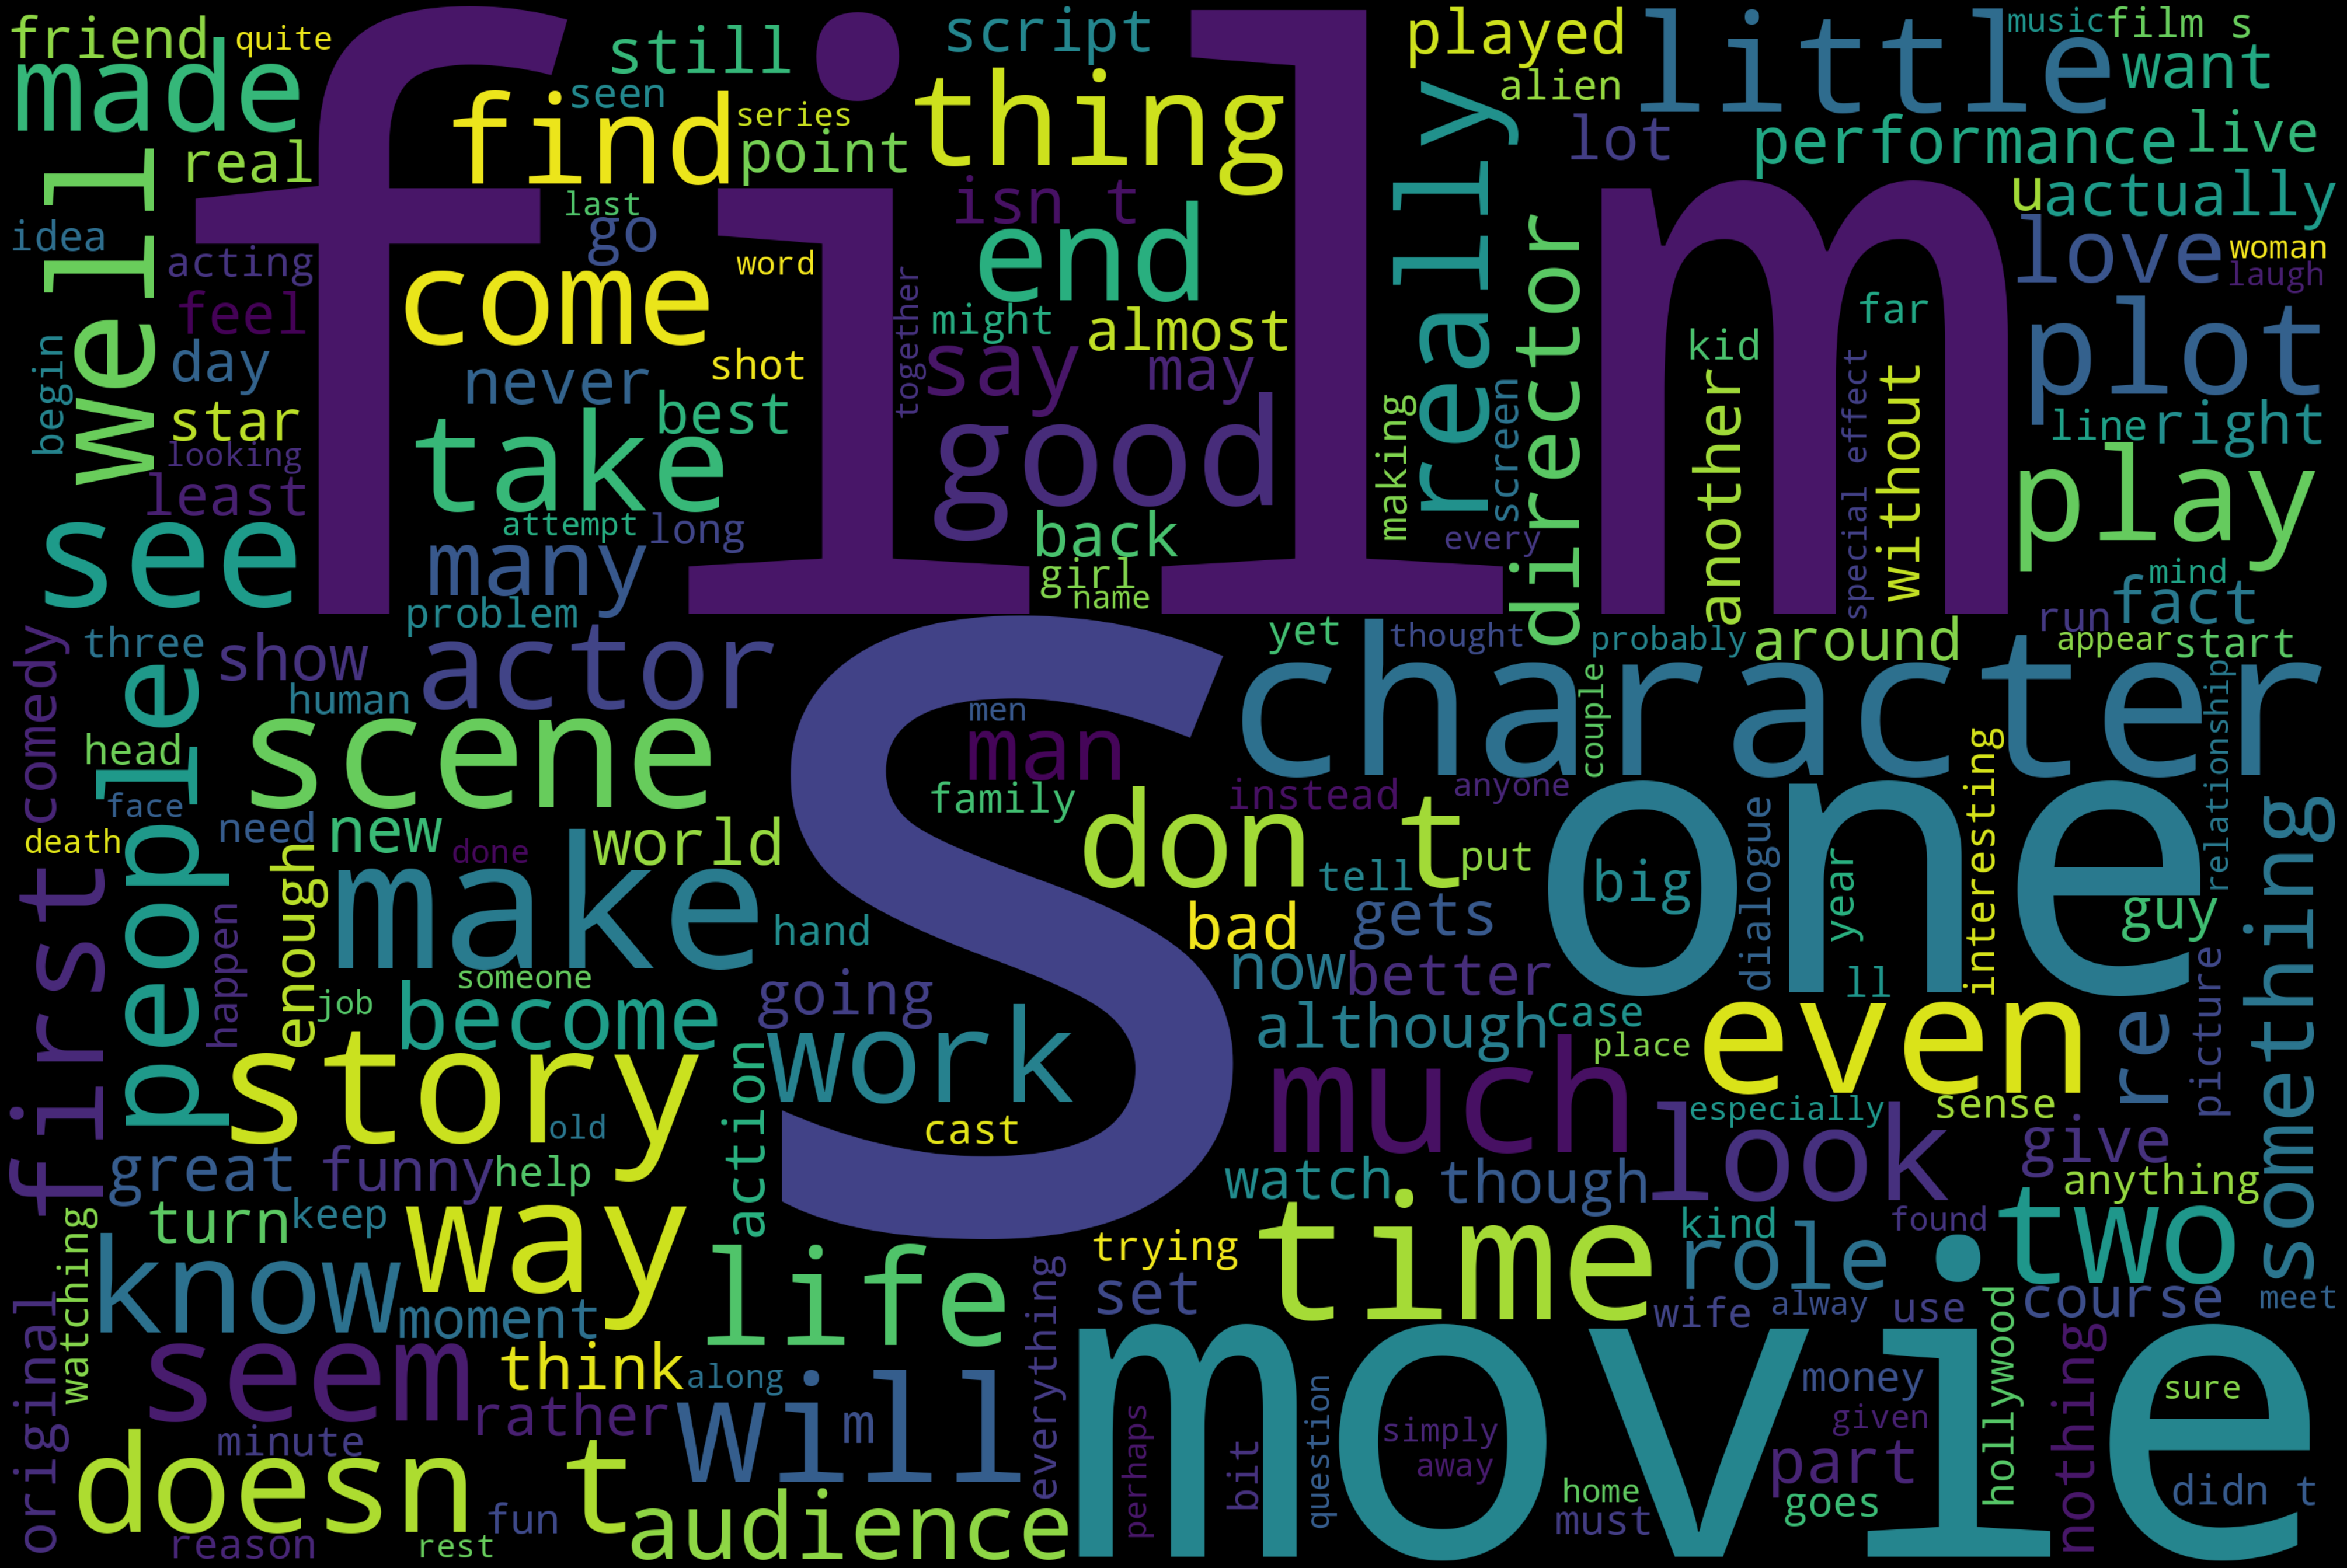

In [25]:
text = " ".join(movies_df["text_without_penctuation"])
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black').generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### 3.1.2.1 Sans stopwords

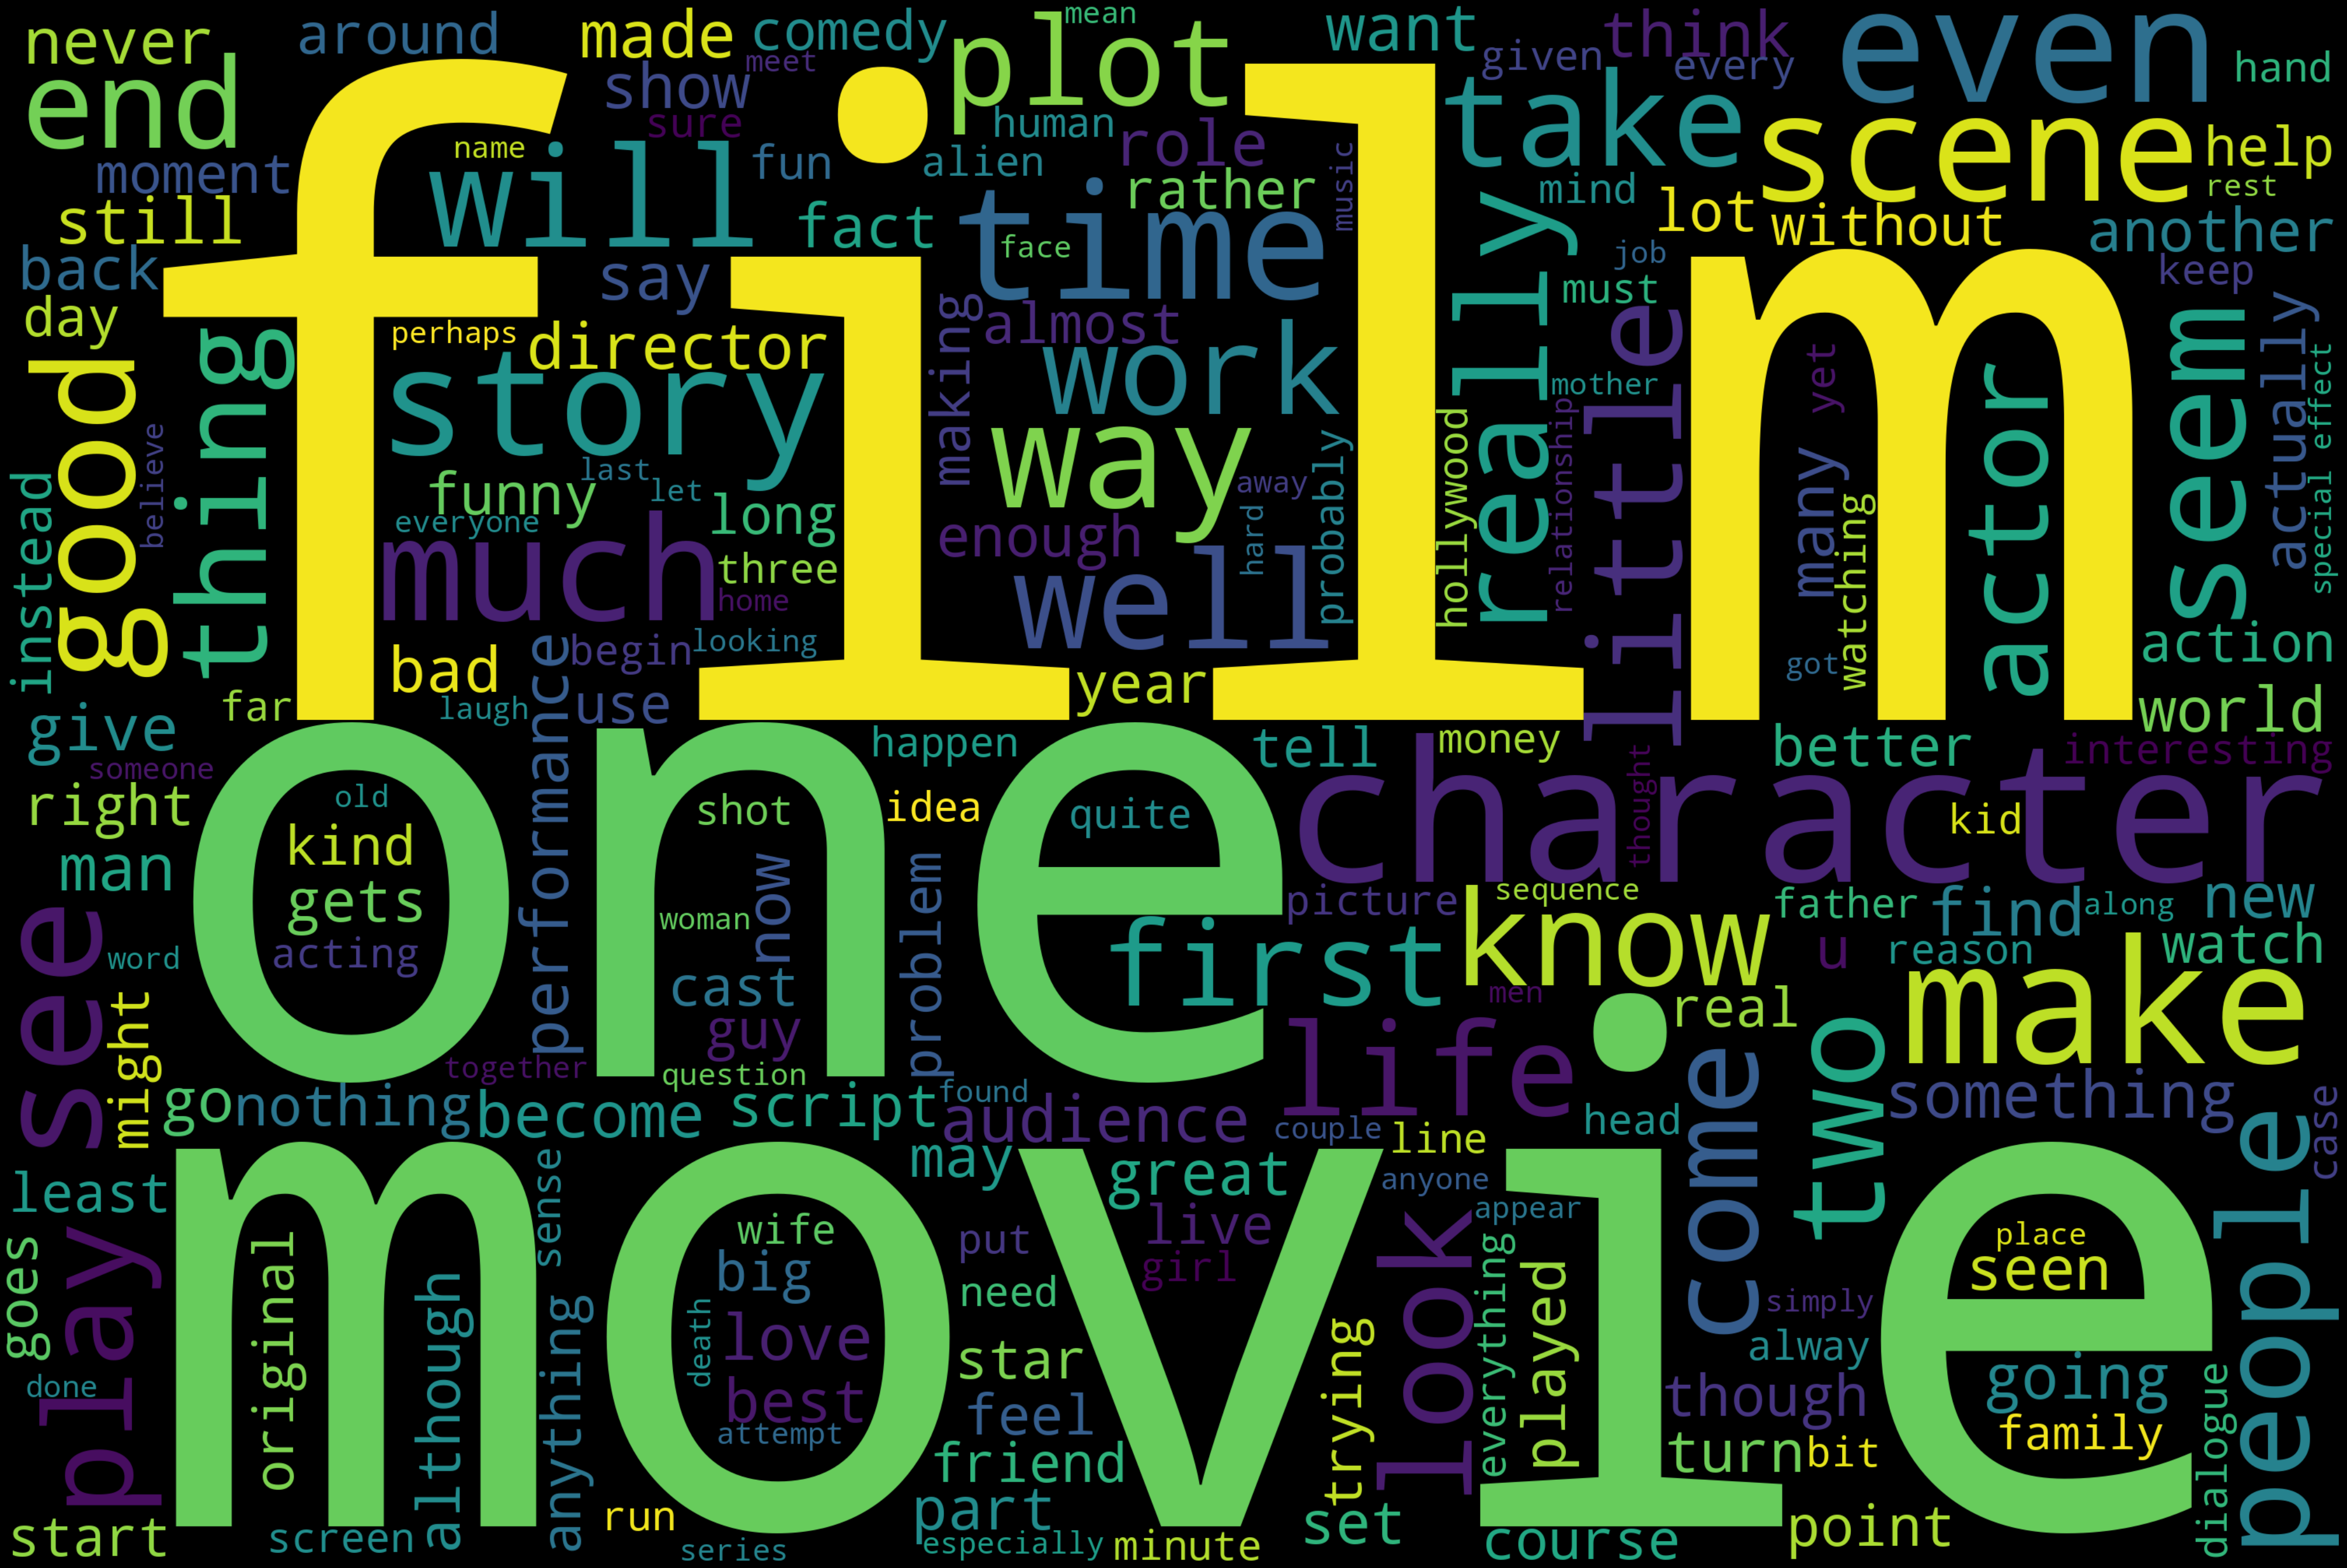

In [9]:
text = " ".join(movies_df["text_without_penctuation"])
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### 3.1.3 Les 100 mots dont la fréquence documentaire est la plus grande

In [31]:
words = " ".join(movies_df["text_without_penctuation"]).split()

# Compter les occurrences des mots
dico = Counter(words)

# Récupérer les 100 mots les plus courants
most_common_words = dict(dico.most_common(100))

print(most_common_words)

{'the': 76574, 'a': 38109, 'and': 35581, 'of': 34126, 'to': 31939, 'is': 25203, 'in': 21827, 's': 18496, 'it': 16106, 'that': 15925, 'as': 11378, 'with': 10792, 'for': 9961, 'his': 9588, 'this': 9579, 'film': 9516, 'i': 8890, 'he': 8864, 'but': 8635, 'on': 7387, 'are': 6950, 't': 6400, 'by': 6262, 'be': 6174, 'one': 5854, 'movie': 5774, 'an': 5744, 'who': 5691, 'not': 5584, 'you': 5314, 'from': 4999, 'at': 4988, 'was': 4940, 'have': 4902, 'they': 4825, 'has': 4719, 'her': 4522, 'all': 4374, 'there': 3770, 'like': 3691, 'so': 3684, 'out': 3637, 'about': 3524, 'up': 3406, 'more': 3350, 'what': 3325, 'when': 3258, 'which': 3161, 'or': 3148, 'she': 3141, 'their': 3123, 'some': 2986, 'just': 2905, 'can': 2883, 'if': 2798, 'we': 2774, 'him': 2634, 'into': 2624, 'even': 2565, 'only': 2495, 'than': 2474, 'no': 2473, 'good': 2411, 'time': 2411, 'most': 2306, 'its': 2270, 'will': 2217, 'story': 2170, 'would': 2110, 'been': 2050, 'much': 2050, 'character': 2020, 'also': 1967, 'get': 1949, 'other'

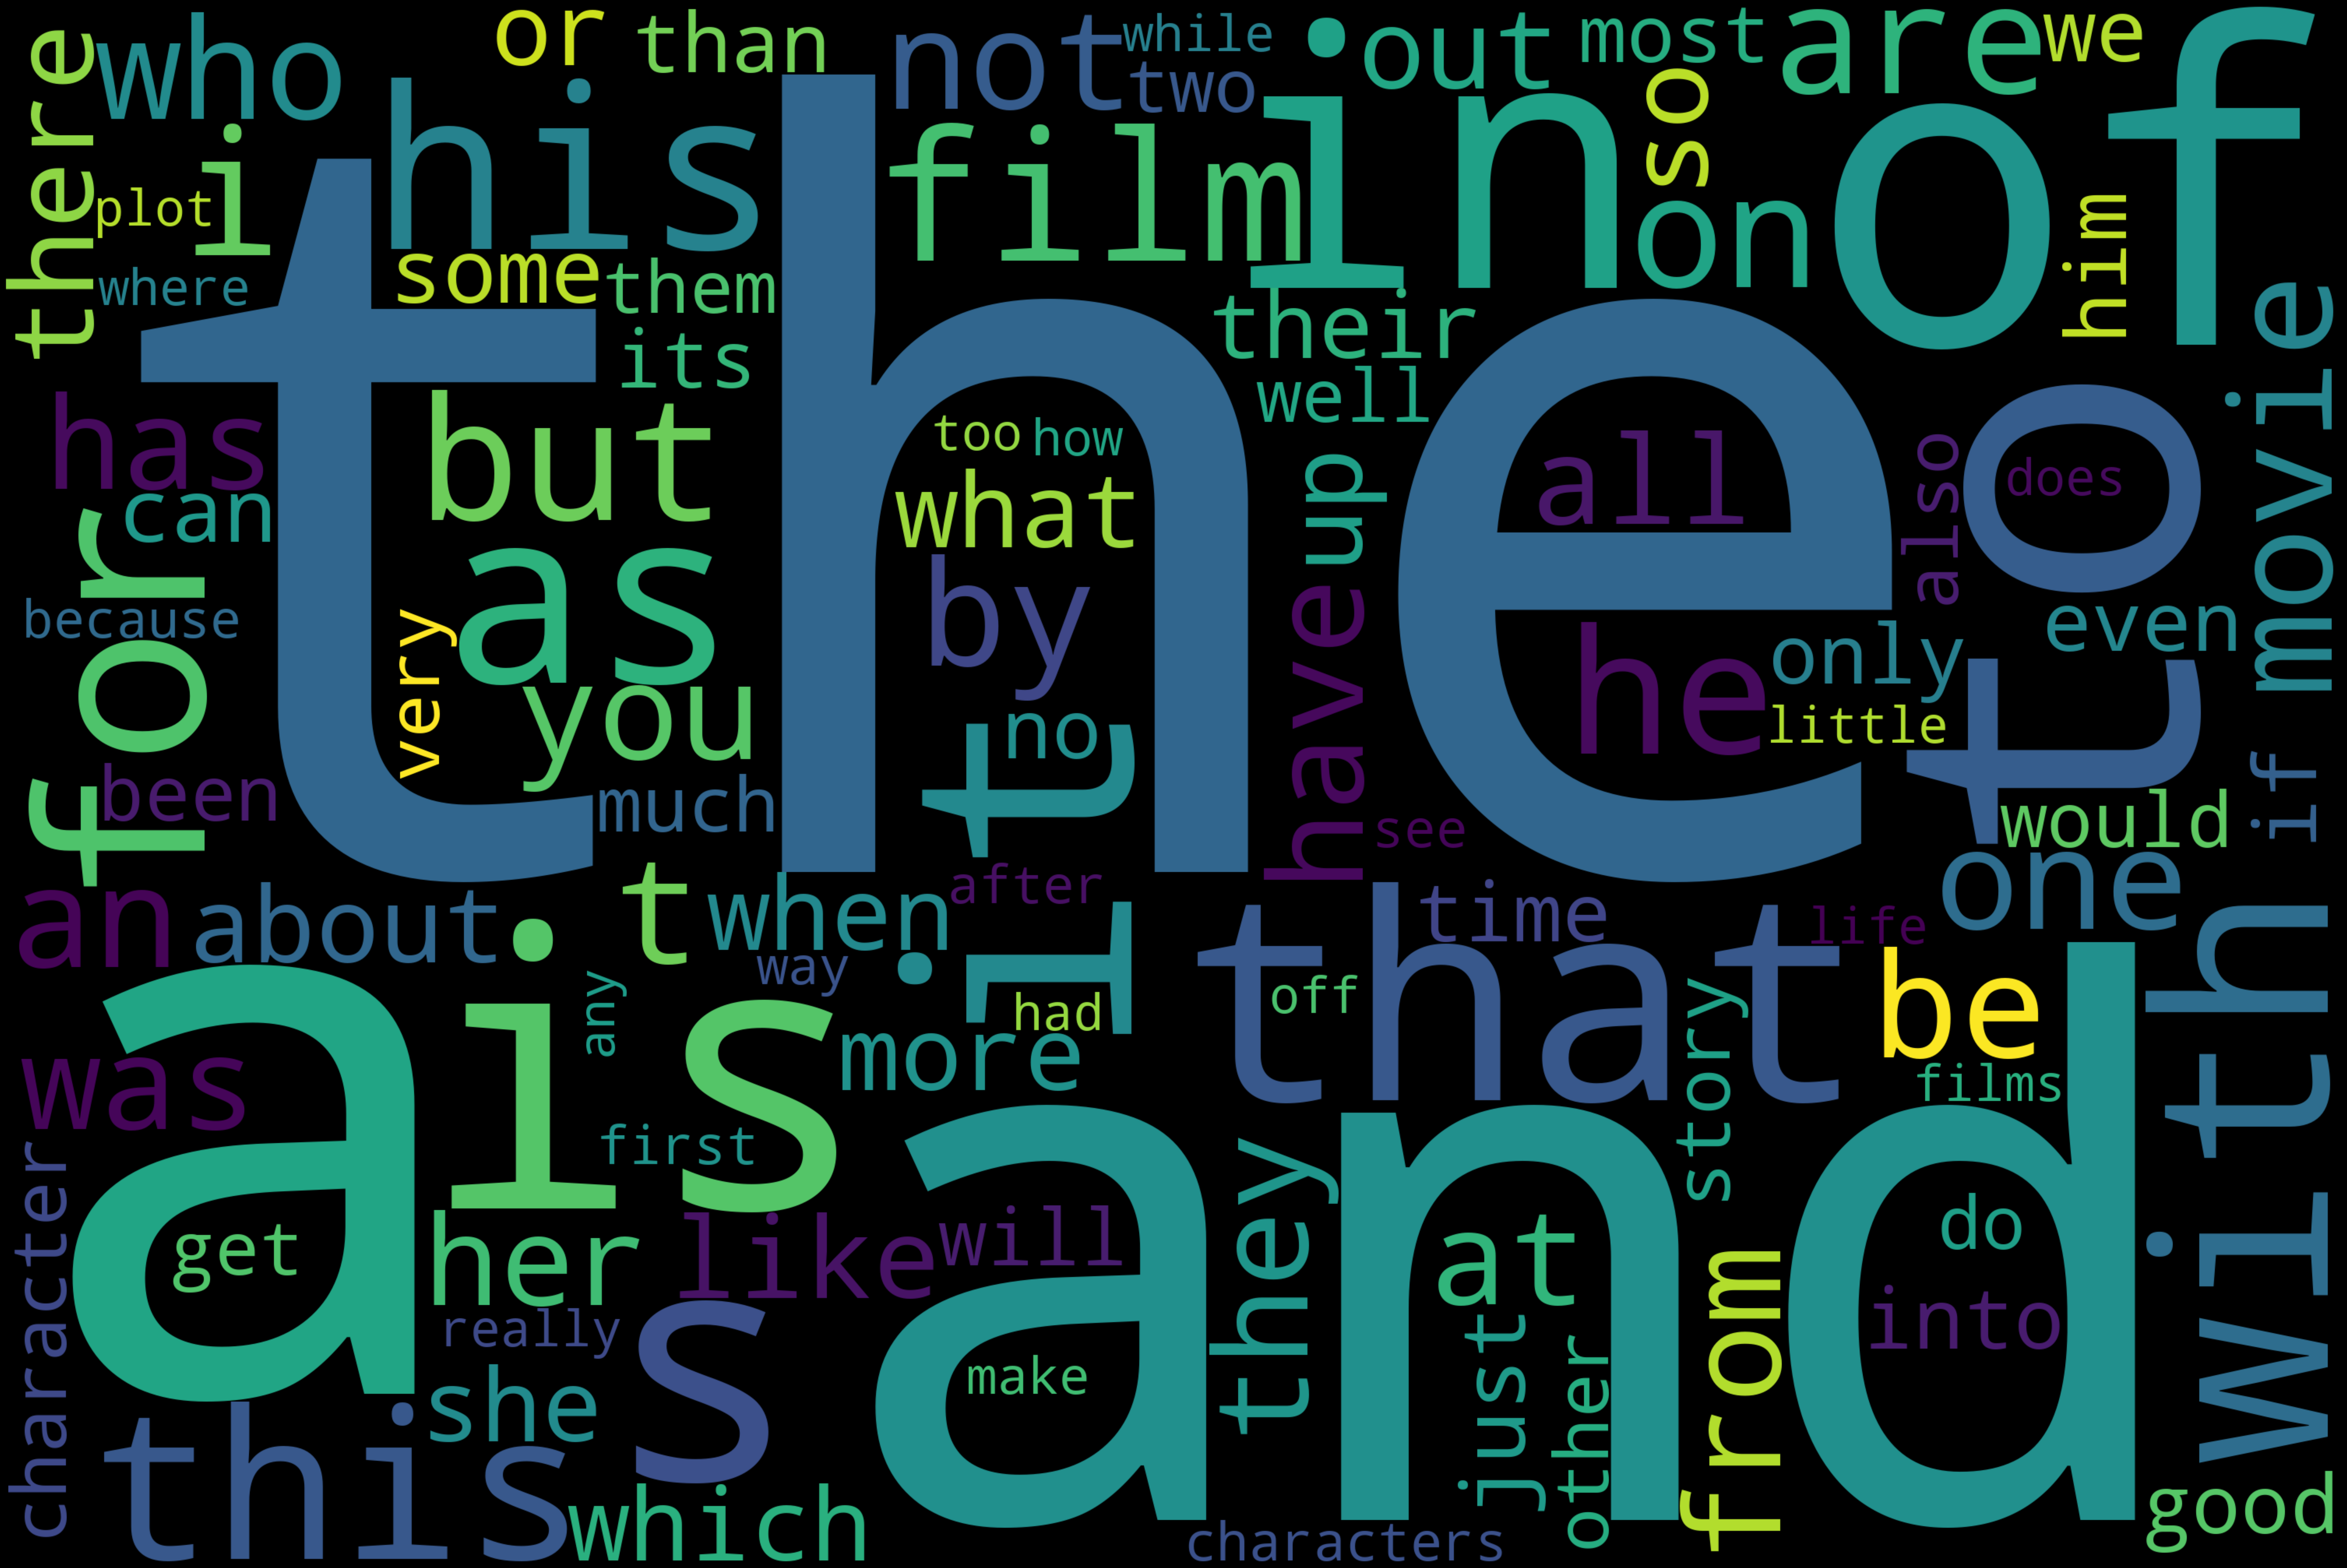

In [32]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black').generate_from_frequencies(most_common_words)
fig = plt.figure(
    figsize = (60, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### 3.1.4 Les 100 mots les plus discriminants au sens de odds ratio

Lorsqu'on parle de mots discriminants en termes d'odds ratio, on fait généralement référence à des mots qui sont fortement associés à une certaine catégorie ou classe par rapport à une autre. Dans ce contexte, nous comparons l'occurrence d'un mot dans une catégorie par rapport à son occurrence dans une autre catégorie.

$\text{Odds ratio}(w) = \frac{\text{Fréquence de } w \text{ dans la classe M} *( { 1 - \text{Fréquence de } w \text{ dans la classe C}}) }{\text{Fréquence de } w \text{ dans la classe C} *( { 1 - \text{Fréquence de } w \text{ dans la classe M}}) }$


In [26]:
def calculate_odds_ratios(pos_counts, neg_counts):
    odds_ratios = {}
    for word in pos_counts.keys():

        count_pos = pos_counts[word] + 0.5 # Avec une correction de Yates pour eviter les div par zerro
        count_neg = neg_counts.get(word, 0)+ 0.5
        
        total_pos = sum(pos_counts.values())
        total_neg = sum(neg_counts.values())

        odds_ratio = (count_pos * (total_neg - count_neg)) / ((count_neg * (total_pos - count_pos))+1)
        odds_ratios[word] = odds_ratio
    
    return odds_ratios

In [27]:
pos_counts =  Counter(' '.join(movies_df[movies_df['label']==1].text).split())
neg_counts = Counter(' '.join(movies_df[movies_df['label']==0].text).split())
odds_ratios = calculate_odds_ratios(pos_counts, neg_counts)

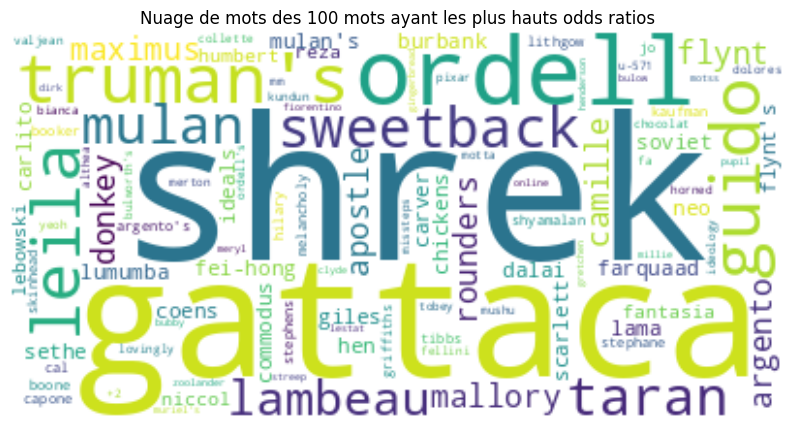

In [28]:
sorted_odds_ratios = sorted(odds_ratios.items(), key=lambda x: x[1], reverse=True)
top_100_odds_ratios = dict(sorted_odds_ratios[:100])


# Générer le nuage de mots
wc = WordCloud(background_color='white').generate_from_frequencies(top_100_odds_ratios)

# Afficher le nuage de mots
plt.figure(figsize=(10, 8))
plt.title('Nuage de mots des 100 mots ayant les plus hauts odds ratios')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

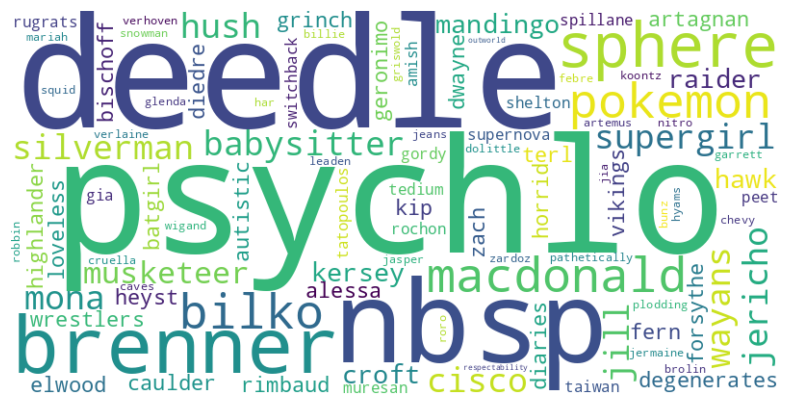

In [36]:
# Calcul de la fréquence de chaque mot pour chaque classe
word_freq_class0 = Counter(" ".join(movies_df[movies_df['label'] == 0]['text_without_penctuation']).split())
word_freq_class1 = Counter(" ".join(movies_df[movies_df['label'] == 1]['text_without_penctuation']).split())

# Calcul de l'odds ratio pour chaque mot
odds_ratios = {}
for word in set(word_freq_class0) | set(word_freq_class1):
    freq_class0 = word_freq_class0.get(word, 0)
    freq_class1 = word_freq_class1.get(word, 0)
    odds_ratios[word] = freq_class0/ (freq_class1 + 1e-6)

# Sélection des 100 mots avec les odds ratio les plus élevés
top_100_discriminating_words = sorted(odds_ratios, key=odds_ratios.get, reverse=True)[:100]

# Création du nuage de mots
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    stopwords=STOPWORDS).generate(" ".join(top_100_discriminating_words))

# Affichage du nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 3.1.5 La distribution d'apparition des mots (Zipf)

La Loi de Zipf est une loi empirique de la distribution des fréquences des mots dans un langage naturel. Elle stipule que, dans une grande quantité de texte, la fréquence d'un mot est inversement proportionnelle à son rang dans l'ordre de fréquence. 

In [7]:
# Comptage des mots dans la colonne 'text' aprés suppresion de la ponctuationx 
movies_df["text_without_penctuation"] = movies_df['text'].apply(lambda x: remove_ponctuation(x.lower())) 
word_counts = movies_df["text_without_penctuation"].str.split(expand=True).stack().value_counts()
word_counts

the               76574
a                 38109
and               35581
of                34126
to                31939
                  ...  
arangements           1
shimmer               1
plagiarize            1
perceptiveness        1
drummond              1
Name: count, Length: 39443, dtype: int64

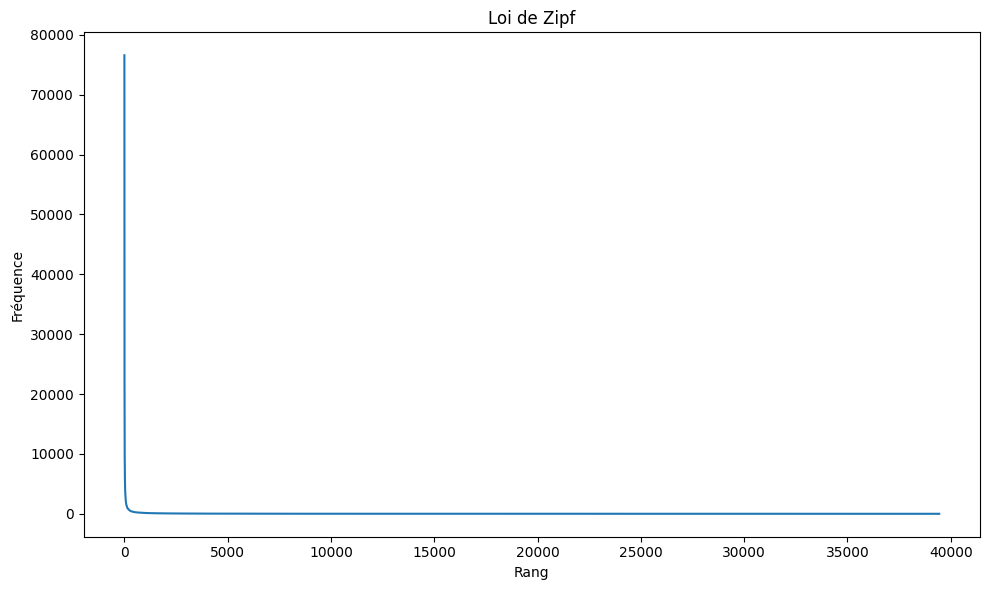

In [9]:
#Tracer le graphe de la loi de Zipf
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(word_counts) + 1), y=word_counts.values)
plt.title('Loi de Zipf')
plt.xlabel('Rang')
plt.ylabel('Fréquence')
plt.tight_layout()
plt.show()

D'aprés ce graphe, on remarque que les fréquences des mots diminuent rapidement avec leur rang. L'utilisation une échelle logarithmique dans ce graphe, nous aidera à mieux visualiser la distribution des mots et à vérifier si les données suivent la loi de Zipf.

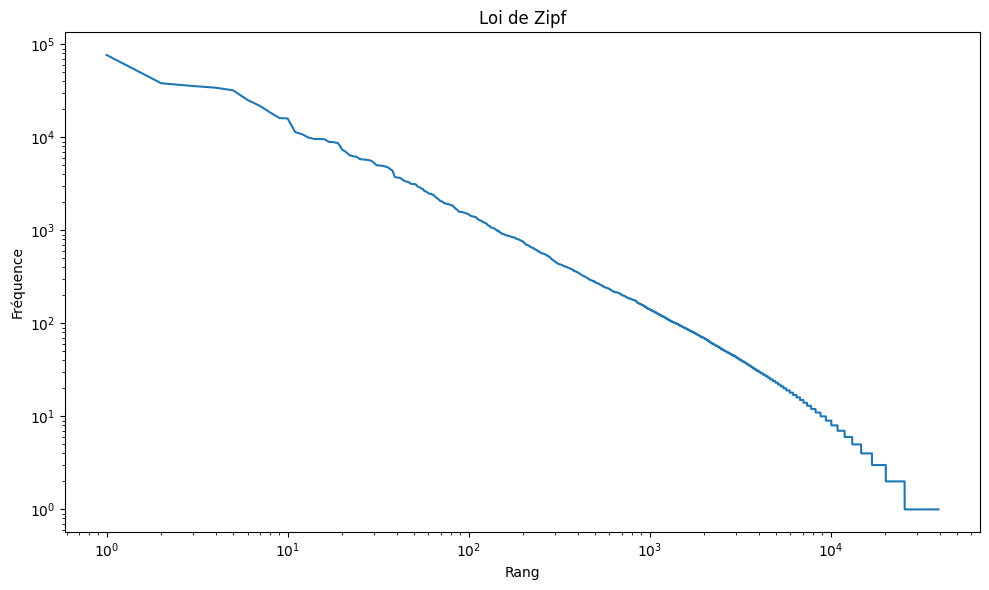

In [21]:
#Tracer le graphe de la loi de Zipf avec l'échelle logarithmique
plt.figure(figsize=(10, 6))
sns.lineplot(x=np.arange(1, len(word_counts) + 1), y=word_counts.values)
plt.title("Loi de Zipf")
plt.xlabel("Rang")
plt.ylabel("Fréquence")
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()
plt.show()


### 3.1.6 Les 100 bigrammes les plus fréquents

#### 3.1.6.1 Avec les stop-words

In [8]:
vectorizer_bigram = CountVectorizer(analyzer='word', ngram_range=(2, 2) )

# Transformer le texte en matrice de comptage des bigrammes
X2 = vectorizer_bigram.fit_transform(movies_df['text_without_penctuation'])

# Obtenir les noms des bigrammes (caractéristiques)
feature_names = vectorizer_bigram.get_feature_names_out()

# Créer un DataFrame à partir de la matrice de comptage des bigrammes
bigram_df = pd.DataFrame(X2.toarray(), columns=feature_names)

# Somme des occurrences de chaque bigramme
bigram_counts = bigram_df.sum()

# Obtenir les 100 bigrammes les plus fréquents
top_100_bigrams = bigram_counts.sort_values(ascending=False).head(100)
print(top_100_bigrams)

of the        8778
in the        5807
the film      4544
to the        2778
to be         2745
              ... 
want to        400
of them        399
would have     396
like the       395
up to          394
Length: 100, dtype: int64


#### 3.1.6.2 Sans les stop-words

In [7]:
vectorizer_bigram_without_SW = CountVectorizer(analyzer='word', ngram_range=(2, 2) , stop_words='english')

# Transformer le texte en matrice de comptage des bigrammes
X2_without_SW = vectorizer_bigram_without_SW.fit_transform(movies_df['text_without_penctuation'])

# Obtenir les noms des bigrammes (caractéristiques)
feature_names = vectorizer_bigram_without_SW.get_feature_names_out()

# Créer un DataFrame à partir de la matrice de comptage des bigrammes
bigram_without_SW_df = pd.DataFrame(X2_without_SW.toarray(), columns=feature_names)

# Somme des occurrences de chaque bigramme
bigram_without_SW_counts = bigram_without_SW_df.sum()

# Obtenir les 100 bigrammes les plus fréquents
top_100_bigrams_witout_SW = bigram_without_SW_counts.sort_values(ascending=False).head(100)
print(top_100_bigrams_witout_SW)

special effects    387
ve seen            279
new york           250
year old           193
high school        188
                  ... 
waste time          57
haven seen          57
jim carrey          57
little bit          56
robin williams      56
Length: 100, dtype: int64


### 3.1.7 Les 100 trigrammes les plus fréquents

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Créer un vecteur CountVectorizer pour les trigrammes
vectorizer_trigram = CountVectorizer(analyzer='word', ngram_range=(3, 3))

# Transformer le texte en matrice de comptage des trigrammes
X_trigram = vectorizer_trigram.fit_transform(movies_df['text_without_penctuation'])

# Créer un DataFrame à partir de la matrice de comptage des trigrammes
trigram_df = pd.DataFrame.sparse.from_spmatrix(X_trigram, columns=vectorizer_trigram.get_feature_names_out())
f
# Somme des occurrences de chaque trigramme
trigram_counts = trigram_df.sum()

# Obtenir les 100 trigrammes les plus fréquents
top_100_trigram = trigram_counts.sort_values(ascending=False).head(100)
print(top_100_trigram)


one of the      1026
of the film      886
in the film      585
the film is      543
of the movie     375
                ... 
to make the       85
by the time       85
of the world      85
by the end        84
is the only       84
Length: 100, dtype: int64


## 3.2 Variantes de BoW

In [ ]:
def fonction_eval(vectorizer,state,alltexts,alllabs):
    X = vectorizer.fit_transform(alltexts)
    [X_train, X_test, Y_train, Y_test]  = train_test_split(X, alllabs, test_size=0.2, random_state=state, shuffle=True)
    

    tps1 = time()
    #Naïve Bayes
    nb_clf = MultinomialNB()
    nb_clf.fit(X_train, Y_train)
    pred_nbt = nb_clf.predict(X_train)
    pred_nb = nb_clf.predict(X_test)
    tps2 = time()
    temps_nb = tps2 - tps1

    tps1 = time()
    #Logistic Regression
    t = 1e-8
    C=100.0
    lr_clf = LogisticRegression(random_state=0, solver='liblinear',max_iter=100, tol=t, C=C)
    lr_clf.fit(X_train, Y_train)
    pred_lrt = lr_clf.predict(X_train)
    pred_lr = lr_clf.predict(X_test)
    tps2 = time()
    temps_lr = tps2 - tps1

    tps1 = time()
    #Linear SVM
    svm_clf = LinearSVC(random_state=0)
    svm_clf.fit(X_train, Y_train)
    pred_svmt = svm_clf.predict(X_train)
    pred_svm = svm_clf.predict(X_test)
    tps2 = time()
    temps_svm = tps2 - tps1


    print("--------------------------------Resultats-----------------------------------")
    print("--------------------------------Naïve Bayes---------------------------------")
    print(f"Accuracy : \t train= {accuracy_score(Y_train, pred_nbt)}, \t test= {accuracy_score(Y_test, pred_nb)}")
    print(f"F1 score : \t train= {f1_score(Y_train, pred_nbt)}, \t test= {f1_score(Y_test, pred_nb)}")
    print(f"Précision : \t train= {precision_score(Y_train, pred_nbt)}, \t test= {precision_score(Y_test, pred_nb)}")
    print(f"Recall : \t train= {recall_score(Y_train, pred_nbt)}, \t test= {recall_score(Y_test, pred_nb)}")
    print(f"ROC AUC :  \t train= {roc_auc_score(Y_train, pred_nbt)}, \t test= {roc_auc_score(Y_test, pred_nb)}")
    print("Temps d'éxécution : ",temps_nb)

    print("\n------------------------------Logistic Regression----------------------------")
    print(f"Accuracy : \t train= {accuracy_score(Y_train, pred_lrt)}, \t test= {accuracy_score(Y_test, pred_lr)}")
    print(f"F1 score : \t train= {f1_score(Y_train, pred_lrt)}, \t test= {f1_score(Y_test, pred_lr)}")
    print(f"Précision : \t train= {precision_score(Y_train, pred_lrt)}, \t test= {precision_score(Y_test, pred_lr)}")
    print(f"Recall : \t train= {recall_score(Y_train, pred_lrt)}, \t test= {recall_score(Y_test, pred_lr)}")
    print(f"ROC AUC : \t train= {roc_auc_score(Y_train, pred_lrt)}, \t test= {roc_auc_score(Y_test, pred_lr)}")
    print("Temps d'éxécution : ",temps_lr)

    print("\n----------------------------------SVM----------------------------------------")
    print(f"Accuracy : \t train= {accuracy_score(Y_train, pred_svmt)}, \t test= {accuracy_score(Y_test, pred_svm)}")
    print(f"F1 score : \t train= {f1_score(Y_train, pred_svmt)}, \t test= {f1_score(Y_test, pred_svm)}")
    print(f"Précision : \t train= {precision_score(Y_train, pred_svmt)}, \t test= {precision_score(Y_test, pred_svm)}")
    print(f"Recall : \t train= {recall_score(Y_train, pred_svmt)}, \t test= {recall_score(Y_test, pred_svm)}")
    print(f"ROC AUC : \t train= {roc_auc_score(Y_train, pred_svmt)}, \t test= {roc_auc_score(Y_test, pred_svm)}")
    print("Temps d'éxécution : ",temps_svm)


-   TF-IDF :

In [ ]:
vectorizer_tf_idf = TfidfVectorizer()
fonction_eval(vectorizer_tf_idf,10,movies_df.text,movies_df.labels)


- Réduction de la taille dy vocabulaire et binary bow: 

In [ ]:
min_df=5             
max_df=0.5
max_features=10000
vectorizer_tf_idf_reduced = TfidfVectorizer(preprocessor=remove_ponctuation,min_df=min_df,max_features=max_features)
fonction_eval(vectorizer_tf_idf_reduced,10,movies_df.text,movies_df.labels)


- Binary Bow :

In [ ]:
vectorizer_tf_idf_bin = TfidfVectorizer(preprocessor=remove_ponctuation,min_df=min_df,max_features=max_features,binary=True)
fonction_eval(vectorizer_tf_idf_bin,10,movies_df.text,movies_df.labels)

-   Bi-grams / Tri_grams :

In [ ]:
vectorizer_tf_idf_bigram = TfidfVectorizer(ngram_range=(2,2),min_df=min_df,max_features=max_features,binary=True)
fonction_eval(vectorizer_tf_idf_bigram,10,movies_df.text,movies_df.labels)

In [ ]:
vectorizer_tf_idf_bigram = TfidfVectorizer(ngram_range=(3,3),min_df=min_df,max_df=max_df,max_features=max_features,binary=True)
fonction_eval(vectorizer_tf_idf_bigram,10,movies_df.text,movies_df.labels)